In [1]:
import pandas as pd
import numpy as np

In [2]:
currency = pd.read_csv('Weekly Value.csv')

In [3]:
currency = currency.sort_index(axis=1 ,ascending=True)
currency = currency.iloc[::-1]
currency = currency.reset_index(drop=True)

In [4]:
currency["Date"] = pd.to_datetime(currency["Date"])

In [7]:
currency_train = currency[522:-13]

In [13]:
# currency_train = currency[:-13]

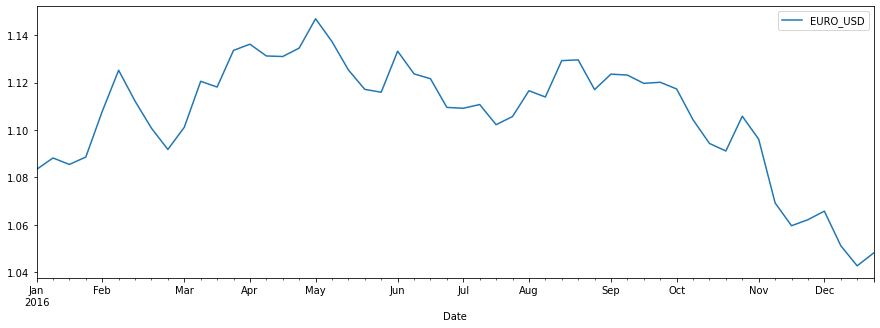

In [8]:
import matplotlib.pyplot as plt
currency_train.plot('Date','EURO_USD',figsize=(15,5))

In [9]:
len(currency_train)

52

<ipython-input-10-8ec561c8c8b3>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  currency_train['Differenced'] = currency_train['EURO_USD'].diff(periods=1)


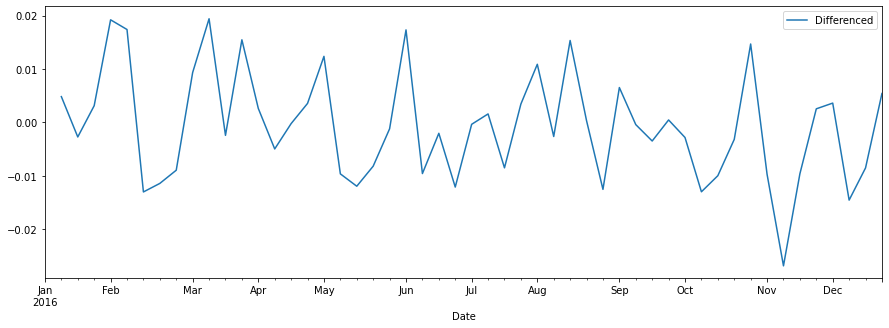

In [10]:
# Step 2: Difference data to make data stationary on mean (remove trend)
currency_train['Differenced'] = currency_train['EURO_USD'].diff(periods=1)
currency_train.plot('Date','Differenced',figsize=(15,5))

<ipython-input-11-cfe9d9237e48>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  currency_train['Log_price'] = np.log10(currency_train['EURO_USD'])


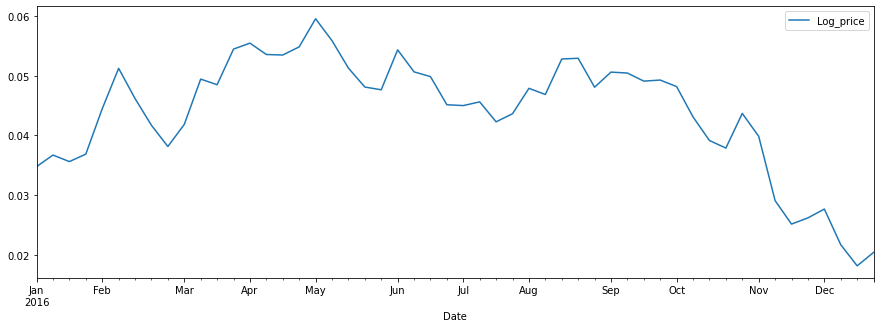

In [11]:
# Step 3: log transform data to make data stationary on variance
import numpy as np
currency_train['Log_price'] = np.log10(currency_train['EURO_USD'])
currency_train.plot('Date','Log_price',figsize=(15,5))

<ipython-input-12-ab443a402be0>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  currency_train['Diff_Log_price'] = currency_train['Log_price'].diff(periods=1)


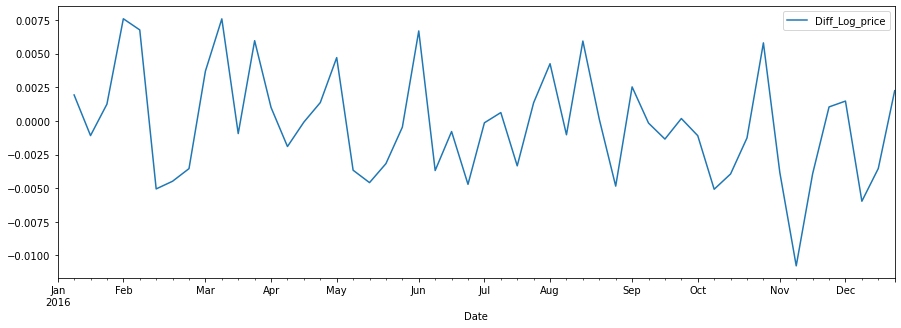

In [12]:
# Step 4: Difference log transform data to make data stationary on both mean and variance
currency_train['Diff_Log_price'] = currency_train['Log_price'].diff(periods=1)
currency_train.plot('Date','Diff_Log_price',figsize=(15,5))

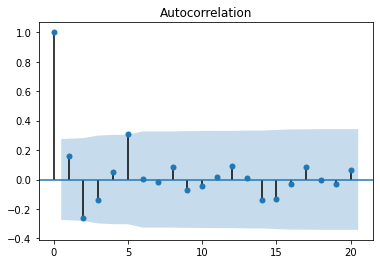

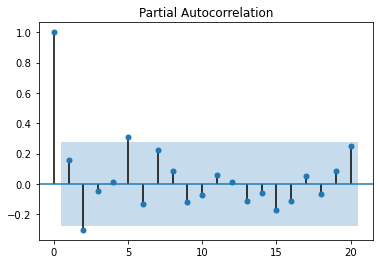

In [13]:
# Step 5: Plot ACF and PACF to identify potential AR and MA model
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
plot_acf(currency_train['Diff_Log_price'][1:],lags=20)
plt.show()
plot_pacf(currency_train['Diff_Log_price'][1:],lags=20)
plt.show()

In [27]:
# Step 6: Identification of best fit ARIMA model
# Ref1: https://alkaline-ml.com/pmdarima/modules/generated/pmdarima.arima.auto_arima.html
from statsmodels.tsa.arima_model import ARIMA
model = ARIMA(currency_train['EURO_USD'], order=(1,0,0))
model_fit = model.fit(disp=-1)
print(model_fit.summary())
pred,se,conf = model_fit.forecast(13, alpha=0.05)
pred
# import pmdarima as pm 
# model = pm.auto_arima(currency_train['EURO_USD'], m = 1,suppress_warnings=True) # m=seasonal length
# model.summary()

                              ARMA Model Results                              
Dep. Variable:               EURO_USD   No. Observations:                   52
Model:                     ARMA(1, 0)   Log Likelihood                 164.589
Method:                       css-mle   S.D. of innovations              0.010
Date:                Sun, 28 Mar 2021   AIC                           -323.178
Time:                        12:46:59   BIC                           -317.324
Sample:                             0   HQIC                          -320.933
                                                                              
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const              1.0912      0.020     54.331      0.000       1.052       1.131
ar.L1.EURO_USD     0.9407      0.046     20.410      0.000       0.850       1.031
                                    

array([1.05066928, 1.05307277, 1.05533375, 1.05746065, 1.05946144,
       1.06134359, 1.06311413, 1.06477969, 1.06634648, 1.06782037,
       1.06920686, 1.07051114, 1.07173808])

In [26]:
# # Step 6: Forecast sales using the best fit ARIMA model

# pred, conf = model.predict(13, return_conf_int=True,alpha=0.05)
# pred

array([1.04409106, 1.03662226, 1.03187689, 1.02713153, 1.02238616,
       1.0176408 , 1.01289543, 1.00815007, 1.0034047 , 0.99865934,
       0.99391397, 0.98916861, 0.98442324])

In [ ]:
data = currency[-13:]
data['Prediction'] = pred_real

In [125]:
data

,Date,EURO_USD,Prediction,lower_bounds,upper_bounds
574,2017-01-02,1.050786,1.051443,1.023636,1.079250
575,2017-01-09,1.060686,1.054140,1.008944,1.099337
576,2017-01-16,1.064371,1.056633,0.997839,1.115428
577,2017-01-23,1.070700,1.059047,0.989111,1.128982
578,2017-01-30,1.074371,1.061417,0.981997,1.140838
579,2017-02-06,1.066157,1.063756,0.976028,1.151485
580,2017-02-13,1.062986,1.066067,0.970912,1.161222
581,2017-02-20,1.058086,1.068351,0.966460,1.170243
582,2017-02-27,1.056086,1.070609,0.962539,1.178678
583,2017-03-06,1.058471,1.072840,0.959057,1.186623


In [16]:
# pred_real = 10**pred
pred_real = pred

data['lower_bounds'] = [i[0] for i in conf ]
data['upper_bounds'] = [i[1] for i in conf ]

NameError: name 'data' is not defined

In [122]:
data.to_csv('prediction.csv')

In [121]:
from sklearn.metrics import r2_score
r2_score(data['EURO_USD'], data['Prediction'])

-0.11630775676539473

In [ ]:
data = data.to_csv('prediction.csv')

Holt Winters Seasonal Method

In [29]:
currency_tr = currency_train[:-13]
currency_tst = currency_train[-13:]

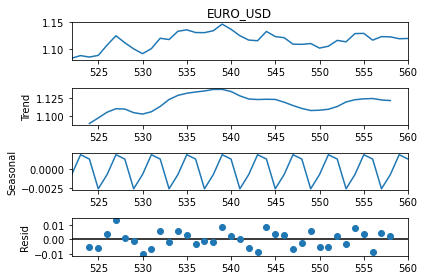

In [33]:
from statsmodels.tsa.seasonal import seasonal_decompose
from matplotlib import pyplot
result = seasonal_decompose(currency_tr['EURO_USD'], model='additive', period = 4)
result.plot()
pyplot.show()

In [34]:
from statsmodels.tsa.api import ExponentialSmoothing
ES_qcement = ExponentialSmoothing(currency_tr['EURO_USD'],trend='add', seasonal='add',seasonal_periods = 4).fit()
ES_qcement.forecast(12)

/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/holtwinters.py:743: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warn("Optimization failed to converge. Check mle_retvals.",


1083    1.615009
1084    1.617005
1085    1.614094
1086    1.615808
1087    1.618801
1088    1.620797
1089    1.617886
1090    1.619600
1091    1.622593
1092    1.624589
1093    1.621678
1094    1.623392
dtype: float64

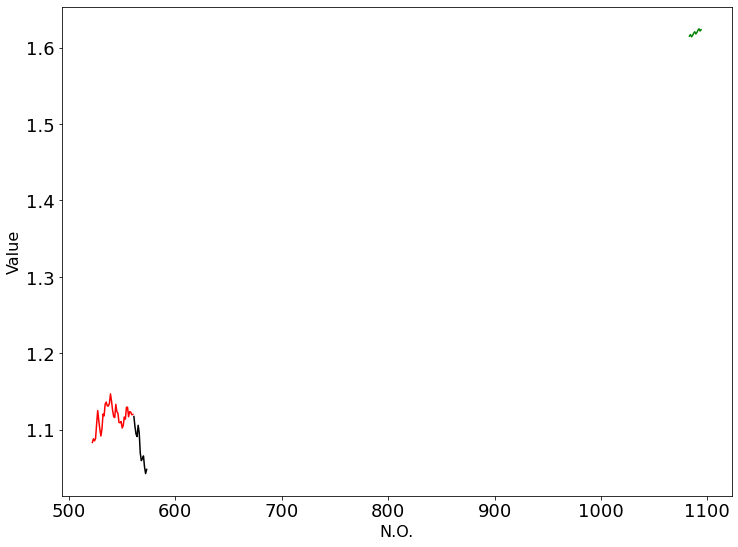

In [35]:
# plot forecasts in test set
import matplotlib.pyplot as plt
fig, ax1 = plt.subplots(figsize=(12, 9))
ax1.plot( list(currency_tst.index), currency_tst['EURO_USD'],linestyle = 'solid', color = 'black', markersize = 1)
ax1.plot( list(currency_tr.index), currency_tr['EURO_USD'],linestyle = 'solid', color = 'red', markersize = 1)
ax1.plot( list(ES_qcement.forecast(12).index), ES_qcement.forecast(12),linestyle = 'solid',color = 'green', markersize = 1)
ax1.ticklabel_format(axis = 'y', style= 'sci',scilimits =(0,3))
ax1.set_xlabel('N.O.',fontsize=16)
ax1.set_ylabel('Value',fontsize=16)
plt.tick_params(labelsize=18)
plt.show()